<a href="https://colab.research.google.com/github/yukieeeo/Neural_Nets_and_Deep_Learning/blob/master/ANLY590HW3_XuejunZhang.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import re
import nltk
nltk.download("stopwords")
import warnings
import pandas as pd
warnings.filterwarnings("ignore")
import numpy as np
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from keras.preprocessing.text import Tokenizer


import keras
import tensorflow as tf
import tensorflow.keras as tfk
from keras.layers import Conv1D
from keras.datasets import cifar10
from keras.models import load_model
from keras.applications import VGG16
from keras.preprocessing import sequence
from keras.models import Model,Sequential
from keras.optimizers import SGD, RMSprop
from sklearn.metrics import roc_curve, auc
from keras.utils.np_utils import to_categorical
from keras.layers import Bidirectional, SimpleRNN
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

from keras.layers import Input, Dense, Flatten, Conv2D, MaxPooling2D, UpSampling2D, \
BatchNormalization, Dropout, Activation, Embedding, SpatialDropout1D, MaxPool1D

tfkl = tfk.layers


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## 1.Autoencoder

In [2]:
#load the CIFAR-10 dataset 
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

In [3]:
#normalize data 
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255
#because data is a 10000x3072 numpy array of uint8s and 
#consist of 60000 32x32 colour images, reshape to 32,32,3 (32*32*3=3072)
x_train = np.reshape(x_train, (len(x_train), 32, 32, 3))  
x_test = np.reshape(x_test, (len(x_test), 32, 32, 3))
print((x_train.shape, x_test.shape))

((50000, 32, 32, 3), (10000, 32, 32, 3))


In [4]:
#Encoding dropout for denoising, batchnormaization for higher learning rate 
input_img = Input(shape=(32, 32, 3))
x = Conv2D(16, (3, 3), padding='same')(input_img)
x = Activation('relu')(x)
x = MaxPooling2D((2, 2), padding='same')(x)

x = Conv2D(32, (3, 3), padding='same')(x)
x = Activation('relu')(x)
x = MaxPooling2D((2, 2), padding='same')(x)

x = Conv2D(64, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

#Decoding
x = Conv2D(64, (3, 3), padding='same')(encoded)
x = Activation('relu')(x)
x = UpSampling2D((2, 2))(x)

x = Conv2D(32, (3, 3), padding='same')(x)
x = Activation('relu')(x)
x = UpSampling2D((2, 2))(x)

x = Conv2D(16, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = UpSampling2D((2, 2))(x)

x = Conv2D(3, (3, 3), padding='same')(x)
decoded = Activation('sigmoid')(x)

In [5]:
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

In [6]:
#train
autoencoder.fit(x_train, x_train,
                epochs=20,
                batch_size=32,
                shuffle=True,
                validation_data=(x_test, x_test))

Epoch 1/20
1563/1563 [==============================] - 173s 111ms/step - loss: 0.7071 - val_loss: 0.6693
Epoch 2/20
1563/1563 [==============================] - 171s 109ms/step - loss: 0.6516 - val_loss: 0.6400
Epoch 3/20
1563/1563 [==============================] - 171s 110ms/step - loss: 0.6338 - val_loss: 0.6280
Epoch 4/20
1563/1563 [==============================] - 174s 111ms/step - loss: 0.6251 - val_loss: 0.6214
Epoch 5/20
1563/1563 [==============================] - 172s 110ms/step - loss: 0.6197 - val_loss: 0.6169
Epoch 6/20
1563/1563 [==============================] - 169s 108ms/step - loss: 0.6159 - val_loss: 0.6136
Epoch 7/20
1563/1563 [==============================] - 168s 108ms/step - loss: 0.6131 - val_loss: 0.6111
Epoch 8/20
1563/1563 [==============================] - 169s 108ms/step - loss: 0.6109 - val_loss: 0.6091
Epoch 9/20
1563/1563 [==============================] - 168s 107ms/step - loss: 0.6091 - val_loss: 0.6074
Epoch 10/20
1563/1563 [=======================

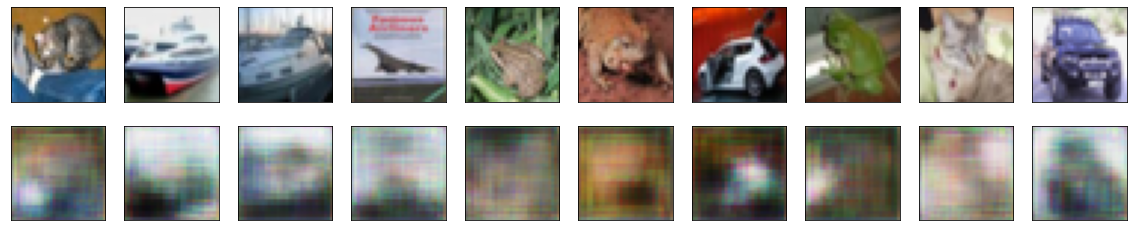

In [9]:
decoded_imgs = autoencoder.predict(x_test)

n = 10
plt.figure(figsize=(20, 4))

for i in range(n):
    # display original
    ax = plt.subplot(2, n, i+1)
    plt.imshow(x_test[i].reshape(32, 32, 3))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + n+1)
    plt.imshow(decoded_imgs[i].reshape(32, 32, 3))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()


# 2. Image Classification

 2.1 Deep CNN

In [11]:
#Reload and normalize the dataset 
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255
x_train = np.reshape(x_train, (len(x_train), 32, 32, 3))  
x_test = np.reshape(x_test, (len(x_test), 32, 32, 3))
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [12]:
model = Sequential()
model.add(tfkl.Conv2D(filters = 16, kernel_size=(2,2), strides=1, 
                      padding="valid", activation='relu', input_shape=(32, 32, 3)))
model.add(tfkl.MaxPool2D(pool_size = 2))
model.add(tfkl.Dropout(0.2))

model.add(tfkl.Conv2D(filters = 32, kernel_size=(2,2), strides=1, 
                      padding="valid", activation='relu'))
model.add(tfkl.MaxPool2D(pool_size = 2))
model.add(tfkl.Dropout(0.2))

model.add(tfkl.Conv2D(filters = 64, kernel_size=(2,2), strides=1, 
                      padding="valid", activation='relu'))
model.add(tfkl.MaxPool2D(pool_size = (2,2)))
model.add(tfkl.Dropout(0.2))

# model.add(tfkl.GlobalMaxPool2D())
# model.add(tfkl.Dense(10, activation='softmax'))

model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(10, activation='softmax'))
model.summary()


model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 31, 31, 16)        208       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 15, 15, 16)        0         
_________________________________________________________________
dropout (Dropout)            (None, 15, 15, 16)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 14, 14, 32)        2080      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 6, 6, 64)          8

In [13]:
model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])

model.fit(x_train, y_train, epochs=20, batch_size = 128,validation_data=(x_test, y_test))

Epoch 1/20
391/391 [==============================] - 33s 84ms/step - loss: 1.9379 - accuracy: 0.2785 - val_loss: 1.6612 - val_accuracy: 0.4003
Epoch 2/20
391/391 [==============================] - 33s 84ms/step - loss: 1.6070 - accuracy: 0.4103 - val_loss: 1.4576 - val_accuracy: 0.4833
Epoch 3/20
391/391 [==============================] - 33s 84ms/step - loss: 1.4926 - accuracy: 0.4567 - val_loss: 1.3597 - val_accuracy: 0.5234
Epoch 4/20
391/391 [==============================] - 34s 86ms/step - loss: 1.4180 - accuracy: 0.4880 - val_loss: 1.3047 - val_accuracy: 0.5432
Epoch 5/20
391/391 [==============================] - 33s 84ms/step - loss: 1.3639 - accuracy: 0.5091 - val_loss: 1.2522 - val_accuracy: 0.5557
Epoch 6/20
391/391 [==============================] - 33s 85ms/step - loss: 1.3224 - accuracy: 0.5235 - val_loss: 1.2206 - val_accuracy: 0.5679
Epoch 7/20
391/391 [==============================] - 33s 85ms/step - loss: 1.2879 - accuracy: 0.5385 - val_loss: 1.2233 - val_accuracy:

In [14]:
# Evaluate the model on test set and training set
test_score = model.evaluate(x_test, y_test)
train_score = model.evaluate(x_train, y_train)
print('The accuracy of the trained model on the test set is:',test_score[1],'The loss is:',test_score[0])
print('The accuracy of the trained model on the training set is:',train_score[1],'The loss is:',train_score[0])

1563/1563 [==============================] - 14s 9ms/step - loss: 0.8625 - accuracy: 0.6993
The accuracy of the trained model on the test set is: 0.6739000082015991 The loss is: 0.937278151512146
The accuracy of the trained model on the training set is: 0.6993399858474731 The loss is: 0.8624560832977295


2.2 Transfer Learning 

In [15]:
conv_base = VGG16(weights="imagenet",include_top=False,input_shape=(32,32,3))
model = Sequential()
model.add(conv_base)
model.add(Flatten())
model.add(Dense(64, activation="relu"))
model.add(Dense(10, activation="sigmoid"))

conv_base.trainable = False
model.summary()

58892288/58889256 [==============================] - 0s 0us/step
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 1, 1, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                32832     
_________________________________________________________________
dense_3 (Dense)              (None, 10)                650       
Total params: 14,748,170
Trainable params: 33,482
Non-trainable params: 14,714,688
_________________________________________________________________


In [ ]:
# model.compile(loss='categorical_crossentropy', optimizer=RMSprop(1e-4),metrics=['accuracy'])
# model.fit(x_train, y_train, epochs=10, batch_size = 64,validation_data=(x_test, y_test))

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])

model.fit(x_train, y_train, epochs=5, batch_size = 128,validation_data=(x_test, y_test))

Epoch 1/5
146/391 [==========>...................] - ETA: 5:16 - loss: 1.6836 - accuracy: 0.4262

In [1]:
# Evaluate the model on test set and training set
test_score = model.evaluate(x_test, y_test)
train_score = model.evaluate(x_train, y_train)
print('The accuracy of the trained model on the test set is:',test_score[1],'The loss is:',test_score[0])
print('The accuracy of the trained model on the training set is:',train_score[1],'The loss is:',train_score[0])

NameError: ignored

# 3. Text Classification

3.1 RNN

In [70]:
#load text data 
spamdd = pd.read_csv("SPAM_detection.csv")
spamdd.head()

,Message,category_val
0,"Go until jurong point, crazy.. Available only ...",0
1,Ok lar... Joking wif u oni...,0
2,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,U dun say so early hor... U c already then say...,0
4,"Nah I don't think he goes to usf, he lives aro...",0


In [71]:
#tokenize the text and set max features and length 
tokenizer = Tokenizer(filters=None, char_level=True)
tokenizer.fit_on_texts(spamdd['Message'])
max_features = 1000
maxlen = spamdd['Message'].str.len().max()

In [72]:
#seperate train and test date 
X = tokenizer.texts_to_sequences(spamdd['Message'])
Y = spamdd['category_val']
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.2)

In [78]:
#pad the embedding words vectors 
X_train = sequence.pad_sequences(X_train, maxlen)
X_test = sequence.pad_sequences(X_test, maxlen)
input_train.shape

(4457, 910)

In [80]:
#fit the RNN model
rnn_model = Sequential()
rnn_model.add(Embedding(max_features, 64))
rnn_model.add(SimpleRNN(32))
rnn_model.add(Dense(1, activation='sigmoid'))
rnn_model.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["acc"])
rnn_model.fit(X_train, Y_train, epochs=5, batch_size=128)

Epoch 1/5
35/35 [==============================] - 10s 300ms/step - loss: 0.3817 - acc: 0.8557
Epoch 2/5
35/35 [==============================] - 11s 304ms/step - loss: 0.2043 - acc: 0.9412
Epoch 3/5
35/35 [==============================] - 11s 304ms/step - loss: 0.2069 - acc: 0.9331
Epoch 4/5
35/35 [==============================] - 11s 305ms/step - loss: 0.1529 - acc: 0.9565
Epoch 5/5
35/35 [==============================] - 11s 302ms/step - loss: 0.1764 - acc: 0.9439


In [83]:
# Evaluate the model on test set and training set
test_score = rnn_model.evaluate(X_test, Y_test, verbose=1)
train_score = rnn_model.evaluate(X_train, Y_train)
print('The accuracy of the trained model on the test set is:',test_score[1],'The loss is:',test_score[0])
print('The accuracy of the trained model on the training set is:',train_score[1],'The loss is:',train_score[0])

140/140 [==============================] - 6s 44ms/step - loss: 0.0934 - acc: 0.9769
The accuracy of the trained model on the test set is: 0.9704036116600037 The loss is: 0.11563903838396072
The accuracy of the trained model on the training set is: 0.9768902659416199 The loss is: 0.0934411808848381


3.2 CNN

In [94]:
#fit the CNN model
cnn_model = Sequential()
cnn_model.add(Embedding(max_features, 64, input_length = maxlen))
cnn_model.add(Conv1D(128,activation='relu', kernel_size=3,padding='valid'))
cnn_model.add(SpatialDropout1D(0.1)) #dropout some sample
cnn_model.add(MaxPool1D())
cnn_model.add(Conv1D(64,activation='relu', kernel_size=3,padding='valid'))
cnn_model.add(SpatialDropout1D(0.1))
cnn_model.add(MaxPool1D())
cnn_model.add(Flatten())
cnn_model.add(Dense(1, activation='sigmoid'))
cnn_model.summary()
cnn_model.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["acc"])
cnn_model.fit(X_train, Y_train, epochs=5, batch_size=128)

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, 910, 64)           64000     
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 908, 128)          24704     
_________________________________________________________________
spatial_dropout1d_5 (Spatial (None, 908, 128)          0         
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 454, 128)          0         
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 452, 64)           24640     
_________________________________________________________________
spatial_dropout1d_6 (Spatial (None, 452, 64)           0         
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 226, 64)         

In [95]:
# Evaluate the model on test set and training set
test_score = cnn_model.evaluate(X_test, Y_test, verbose=1)
train_score = cnn_model.evaluate(X_train, Y_train)
print('The accuracy of the trained model on the test set is:',test_score[1],'The loss is:',test_score[0])
print('The accuracy of the trained model on the training set is:',train_score[1],'The loss is:',train_score[0])

140/140 [==============================] - 8s 58ms/step - loss: 0.0546 - acc: 0.9850
The accuracy of the trained model on the test set is: 0.9704036116600037 The loss is: 0.10101240128278732
The accuracy of the trained model on the training set is: 0.9849674701690674 The loss is: 0.0546114519238472


3.3 ROC Cruve

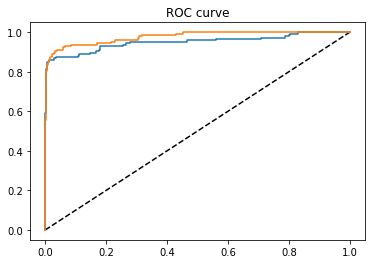

RNN Accuracy (Blue) 0.950237441354846
CNN Accuracy (Orange) 0.9770711751916695


In [102]:
pred_y_rnn = rnn_model.predict(X_test).ravel()
fpr_rnn, tpr_rnn, rnn_ = roc_curve(Y_test, pred_y_rnn)

pred_y_cnn = cnn_model.predict(X_test).ravel()
fpr_cnn, tpr_cnn, cnn_ = roc_curve(Y_test, pred_y_cnn)

auc_rnn = auc(fpr_rnn, tpr_rnn)
auc_cnn = auc(fpr_cnn, tpr_cnn)


plt.figure()
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rnn, tpr_rnn)
plt.plot(fpr_cnn, tpr_cnn)
plt.title('ROC curve')
plt.show()

print("RNN Accuracy (Blue)", auc_rnn)
print("CNN Accuracy (Orange)", auc_cnn)